In [1]:
pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
import zipfile
import shutil
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import splitfolders

from shutil import copyfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from keras.layers import Dense, InputLayer, Dropout, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping as ES
from IPython.display import clear_output as cls
from collections import defaultdict

import plotly.express as px
import matplotlib.pyplot as plt

In [3]:
!gdown --id 1Uj3O9QK758M_NkMxPEgdYPmDWzzjDwyF

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1Uj3O9QK758M_NkMxPEgdYPmDWzzjDwyF
To: /content/AppleLeaf9-.zip
100% 1.02G/1.02G [00:13<00:00, 72.9MB/s]


In [4]:
filenamezip = "/content/AppleLeaf9-.zip"

with zipfile.ZipFile(filenamezip, 'r') as extrzip:
    extrzip.extractall("/content")
    extrzip.close()

In [5]:
root_dir = '/content/AppleLeaf9-'

classes = sorted(os.listdir(root_dir))
classes

['Alternaria leaf spot',
 'Frogeye leaf spot',
 'Health',
 'Mosaic',
 'Powdery mildew',
 'Rust',
 'Scab']

In [6]:
amountpclass = [len(os.listdir(root_dir + '/' + name)) for name in classes]
amountpclass

[417, 3181, 516, 371, 1184, 2753, 3600]

In [7]:
source_path = '/content/AppleLeaf9-'
split_path = '/content/AppleDataset'

splitfolders.ratio(source_path, split_path, seed=47, ratio=(0.9, 0.05, 0.05), group_prefix=None)

Copying files: 12022 files [00:03, 3063.61 files/s]


In [8]:
train_set = '/content/AppleDataset/train'
val_set = '/content/AppleDataset/val'
test_set = '/content/AppleDataset/test'

In [9]:
classes_trset_len = [len(os.listdir(train_set + '/' + name)) for name in classes]
classes_vlset_len = [len(os.listdir(val_set + '/' + name)) for name in classes]
classes_tsset_len = [len(os.listdir(test_set + '/' + name)) for name in classes]
print(classes_trset_len)
print(classes_vlset_len)
print(classes_tsset_len)

[375, 2862, 464, 333, 1065, 2477, 3240]
[20, 159, 25, 18, 59, 137, 180]
[22, 160, 27, 20, 60, 139, 180]


In [10]:
train_datagen = ImageDataGenerator(rescale=(1./255.),
                               rotation_range = 40,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True,
                               validation_split=0.2)
val_datagen = ImageDataGenerator(rescale=(1./255.))

In [11]:
batchSize = 32
imageShape = (256, 256)

train_generator = train_datagen.flow_from_directory(train_set,
                                         target_size=imageShape,
                                         batch_size=batchSize,
                                         class_mode='categorical',
                                         shuffle=True)
val_generator = val_datagen.flow_from_directory(val_set,
                                       target_size=imageShape,
                                       batch_size=batchSize,
                                       class_mode='categorical',
                                       shuffle=True)
test_generator = val_datagen.flow_from_directory(test_set,
                                      target_size=imageShape,
                                      batch_size=batchSize,
                                      class_mode='categorical',
                                      shuffle=True)

Found 10816 images belonging to 7 classes.
Found 598 images belonging to 7 classes.
Found 608 images belonging to 7 classes.


In [12]:
 model = tf.keras.models.Sequential([tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(256, 256, 3)),
                                     tf.keras.layers.MaxPooling2D(2,2),
                                     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(2,2),
                                     tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
                                     tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(2,2),                                     
                                     tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
                                     tf.keras.layers.MaxPooling2D(2,2),
                                     tf.keras.layers.GlobalAveragePooling2D(),
                                     tf.keras.layers.Dense(512, activation='relu'),
                                     tf.keras.layers.Dense(256, activation='relu'),
                                     tf.keras.layers.Dropout(0.2),
                                     tf.keras.layers.Dense(7, activation='softmax')                            
 ])

In [13]:
model.summary()

model.compile(loss="categorical_crossentropy",
             optimizer="adam",
             metrics=["accuracy"]
              )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 58, 58, 128)       7

In [14]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):

    # Check accuracy
    if(logs.get('accuracy') > 0.95):

      # Stop if threshold is met
      print("\nAccuracy is higher than 0.95 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [ ]:
history = model.fit(train_generator,
                   epochs=30,
                   validation_data=val_generator,
                   validation_steps=len(val_generator),
                   callbacks=[callbacks],
                   verbose=1,
                  )

Epoch 1/30
338/338 [==============================] - 298s 840ms/step - loss: 1.4962 - accuracy: 0.3550 - val_loss: 1.3296 - val_accuracy: 0.4164
Epoch 2/30
338/338 [==============================] - 280s 828ms/step - loss: 1.2355 - accuracy: 0.4751 - val_loss: 1.0674 - val_accuracy: 0.5769
Epoch 3/30
338/338 [==============================] - 280s 829ms/step - loss: 0.8444 - accuracy: 0.6968 - val_loss: 0.7385 - val_accuracy: 0.7274
Epoch 4/30
338/338 [==============================] - 287s 848ms/step - loss: 0.7162 - accuracy: 0.7469 - val_loss: 0.6699 - val_accuracy: 0.7559
Epoch 5/30
338/338 [==============================] - 284s 840ms/step - loss: 0.6361 - accuracy: 0.7730 - val_loss: 0.5950 - val_accuracy: 0.7742
Epoch 6/30
338/338 [==============================] - 277s 820ms/step - loss: 0.5643 - accuracy: 0.8054 - val_loss: 0.5259 - val_accuracy: 0.8177
Epoch 7/30
338/338 [==============================] - 284s 840ms/step - loss: 0.5258 - accuracy: 0.8177 - val_loss: 0.4927 -

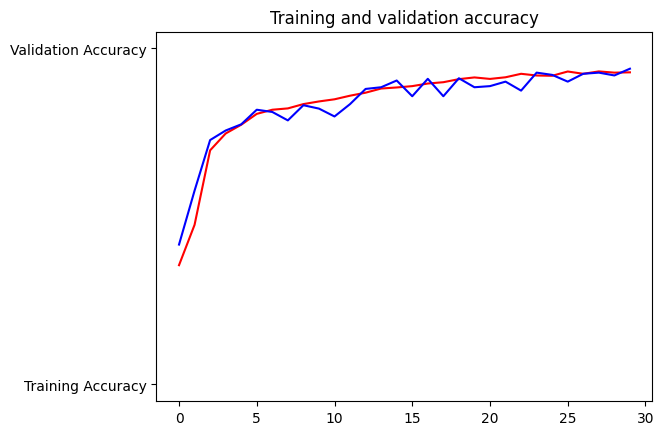

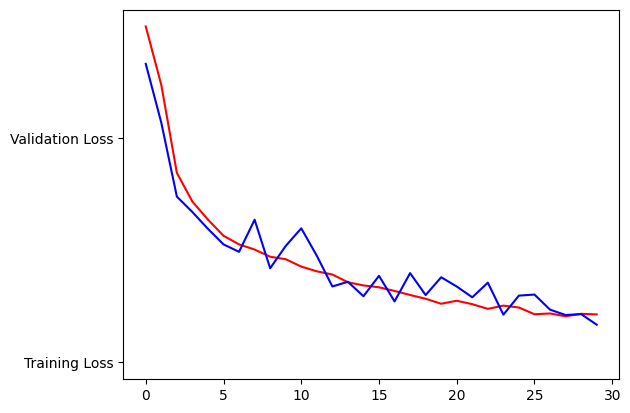

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
print(model.metrics_names)
model.evaluate(test_generator)

['loss', 'accuracy']
19/19 [==============================] - 7s 383ms/step - loss: 0.2084 - accuracy: 0.9375


[0.20837317407131195, 0.9375]

In [ ]:
from google.colab import files

uploaded = files.upload()

Saving 6-8powderyMildew.jpg to 6-8powderyMildew (1).jpg


In [ ]:
test_file = list(uploaded.keys())[0]
test_path = f'/content/{test_file}'

test_image = tf.keras.utils.load_img(test_path, target_size = (256, 256), color_mode='rgb')
test_array = tf.keras.utils.img_to_array(test_image)
test_array = np.array(test_array)
test_array = test_array/255
test_array_predict = np.expand_dims(test_array, axis=0)
print(test_array_predict.shape)

(1, 256, 256, 3)


1/1 [==============================] - 0s 20ms/step
[[0.00280575 0.01815395 0.36628467 0.01505941 0.41941002 0.01983325
  0.15845294]]


[4]
Powdery mildew


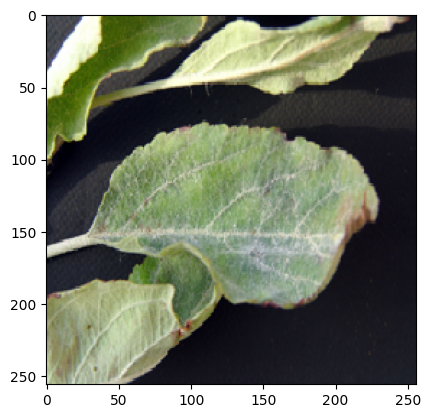

In [ ]:
prediction = model.predict(test_array_predict)
print(prediction)
print("\n")

pred_index = prediction.argmax(axis=-1)
print(pred_index)
idx_to_cls = {v: k for k, v in train_generator.class_indices.items()}
print(idx_to_cls[int(pred_index)])

plt.imshow(test_array)

In [21]:
model.save("model-apple-nontf.h5")

In [22]:
model = tf.keras.models.load_model('model-apple-nontf.h5')

# Convert the model to TFLite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [26]:
import pathlib

tflite_model_file = pathlib.Path('model-apple.tflite')
tflite_model_file.write_bytes(tflite_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
try:
    from google.colab import files
    files.download(tflite_model_file)
except:
    pass